In [169]:
from planet import api
from planet.api import filters
from sys import stdout
import urllib.request
import shutil
from requests.auth import HTTPBasicAuth
import os
import time
import requests
import cv2
import glob
import subprocess
import rasterio
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import wikipedia

In [170]:
title = input("Please input your volcano of interest:")

Please input your volcano of interest:Anak Krakatoa


In [171]:
page = wikipedia.WikipediaPage(title)

In [172]:
lat = float(page.coordinates[0])
long = float(page.coordinates[1])

In [173]:
start_date = input("Please input your start date (YYYY-MM-DD):")

Please input your start date (YYYY-MM-DD):2018-11-01


In [174]:
end_date = input("Please input your end date (YYYY-MM-DD):")

Please input your end date (YYYY-MM-DD):2018-12-31


In [175]:
api_key = input("Please input you Planet API key:") 

Please input you Planet API key:fa8bc840c2af4b52a4f6a69e3489fd10


In [176]:
client = api.ClientV1(api_key) 
PL_API_KEY = api_key

In [177]:
geo_json_geometry = {
  "type": "Polygon",
        "coordinates": [
          [
            [
              long - 0.07,
              lat + 0.07
            ],
            [
              long + 0.07,
              lat + 0.07
            ],
            [
              long + 0.07,
              lat - 0.07
            ],
            [
              long - 0.07,
              lat - 0.07
            ],
            [
              long - 0.07,
              lat + 0.07
            ]
          ]
        ]
      }

In [178]:
geometry_filter = {
    "type": "GeometryFilter",
    "field_name": "geometry",
    "config": geo_json_geometry
}

In [179]:
date_range_filter = {
    "type": "DateRangeFilter",
    "field_name": "acquired",
    "config": {
        "gte": start_date + "T00:00:00.000Z",
        "lte": end_date + "T00:00:00.000Z"
    }
}

In [180]:
cloud_cover_filter = {
    "type": "RangeFilter",
    "field_name": "cloud_cover",
    "config": {
        "lte": 0.2,
    }
}

In [181]:
item_types = ['PSScene4Band']
asset_type = 'analytic'

In [182]:
query = {
    "type": "AndFilter",
    "config": [geometry_filter, date_range_filter, cloud_cover_filter]
}

In [183]:
request = filters.build_search_request(
    query, item_types
)

In [184]:
dataset = client.quick_search(request)

stdout.write('id,cloud_cover,date\n')

id,cloud_cover,date


In [185]:
for item in dataset.items_iter(limit=None):
    props = item['properties']
    stdout.write('{0},{cloud_cover},{acquired}\n'.format(item['id'], **props))

20181230_025232_102e,0.17,2018-12-30T02:52:32.968183Z
20181230_025229_102e,0.14,2018-12-30T02:52:29.831892Z
20181220_025049_0f35,0.09,2018-12-20T02:50:49.183611Z
20181220_025048_0f35,0.13,2018-12-20T02:50:48.144472Z
20181220_025047_0f35,0.07,2018-12-20T02:50:47.105333Z
20181217_025142_101e,0.01,2018-12-17T02:51:42.296592Z
20181217_025144_101e,0.01,2018-12-17T02:51:44.363859Z
20181217_025143_101e,0.01,2018-12-17T02:51:43.330487Z
20181218_031148_0f33,0.17,2018-12-18T03:11:48.793389Z
20181218_031147_0f33,0.08,2018-12-18T03:11:47.844952Z
20181127_031503_1048,0.06,2018-11-27T03:15:03.598717Z
20181124_025200_0f15,0,2018-11-24T02:52:00.180092Z
20181124_025159_0f15,0.03,2018-11-24T02:51:59.145147Z
20181119_025022_103c,0.02,2018-11-19T02:50:22.454971Z
20181117_024659_0e20,0.01,2018-11-17T02:46:59.204854Z
20181117_024701_0e20,0.02,2018-11-17T02:47:01.281035Z
20181117_024700_0e20,0.03,2018-11-17T02:47:00.242945Z
20181116_025055_1008,0,2018-11-16T02:50:55.681319Z
20181116_025054_1008,0.01,2018-11-

In [188]:
for i in item_types:
    request = api.filters.build_search_request(query, [i])  # ,name = None, interval= 'day')
    dataset = client.quick_search(request)
    print(i)
    for item in dataset.items_iter(limit=50):
        print(item['id'])
        session = requests.Session()
        session.auth = (PL_API_KEY, '')
        results = \
            session.get(
                ("https://api.planet.com/data/v1/item-types/" +
                 "{}/items/{}/assets/").format(i, item['id']))
       
        item_activation_url = results.json()[asset_type]["_links"]["activate"]
       
        response = session.post(item_activation_url)
        print(response.status_code)
        while response.status_code != 204:
            time.sleep(30)
            response = session.post(item_activation_url)
            response.status_code = response.status_code
            print(response.status_code)
        
        item_url = 'https://api.planet.com/data/v1/item-types/{}/items/{}/assets'.format(i, item['id'])
        result = requests.get(item_url, auth=HTTPBasicAuth(PL_API_KEY, ''))
        download_url = result.json()[asset_type]['location']  # KeyError: 'location'
        output_file = item['id'] + '.tif'

        with urllib.request.urlopen(download_url) as response, open(output_file, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)

PSScene4Band
20181230_025232_102e
204
20181230_025229_102e
204
20181220_025049_0f35
204
20181220_025048_0f35
204
20181220_025047_0f35
202
202
202
202
202
202
204
20181217_025142_101e
204
20181217_025144_101e
204
20181217_025143_101e
204
20181218_031148_0f33
204
20181218_031147_0f33
204
20181127_031503_1048
202
202
202
202
202
204
20181124_025200_0f15
202
202
202
202
204
20181124_025159_0f15
202
202
202
202
204
20181119_025022_103c
202
202
202
202
204
20181117_024659_0e20
202
202
202
202
202
204
20181117_024701_0e20
202
202
202
202
202
204
20181117_024700_0e20
202
202
202
202
202
204
20181116_025055_1008
202
202
202
202
204
20181116_025054_1008
202
202
202
202
202
204
20181116_025053_1008
202
202
202
202
202
204
20181116_025052_1008
202
202
202
202
204
20181116_031618_1049
202
202
202
202
204
20181116_031617_1049
202
202
202
202
204
20181116_031619_1049
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
204
20181106_024821_0e3a
202
202
202
202
204
20181106_031800_0f49
2

In [189]:
os.getcwd()
os.mkdir('Original_Imagery')

In [190]:
sp = os.getcwd()
sf = os.listdir(sp)
dp = sp + ('\\Original_Imagery')
for file in sf:
    if file.endswith('.tif'):
        shutil.move(os.path.join(sp,file), os.path.join(dp, file))

In [191]:
images = [f for f in os.listdir(dp) if os.path.isfile(os.path.join(dp, f))]

for image in images:
    folder_name = image.split('_')[0]

    new_path = os.path.join(dp, folder_name)
    if not os.path.exists(new_path):
        os.makedirs(new_path)

    old_image_path = os.path.join(dp, image)
    new_image_path = os.path.join(new_path, image)
    shutil.move(old_image_path, new_image_path)

In [192]:
folders = []
for r, d, f in os.walk(dp):
    for folder in d:
        folders.append(os.path.join(r, folder))

i = 0
for x in folders:
    files_to_mosaic = glob.glob(folders[i] + '/*.tif')
    files_string = " ".join(files_to_mosaic)
    command = "python " + sp + "\gdal_merge.py -o "+ files_string[-33:-25] + ".tif" + " -of gtiff " + files_string
    print(command)
    i = i + 1
    output = subprocess.getoutput(command)
    print(output)

python C:\Users\cengelso\Documents\IONS\gdal_merge.py -o 20181101.tif -of gtiff C:\Users\cengelso\Documents\IONS\Original_Imagery\20181101\20181101_025041_101e.tif C:\Users\cengelso\Documents\IONS\Original_Imagery\20181101\20181101_025042_101e.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
python C:\Users\cengelso\Documents\IONS\gdal_merge.py -o 20181106.tif -of gtiff C:\Users\cengelso\Documents\IONS\Original_Imagery\20181106\20181106_024821_0e3a.tif C:\Users\cengelso\Documents\IONS\Original_Imagery\20181106\20181106_031757_0f49.tif C:\Users\cengelso\Documents\IONS\Original_Imagery\20181106\20181106_031758_0f49.tif C:\Users\cengelso\Documents\IONS\Original_Imagery\20181106\20181106_031759_0f49.tif C:\Users\cengelso\Documents\IONS\Original_Imagery\20181106\20181106_031800_0f49.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
python C:\Users\cengelso\Documents\IONS\gdal_merge.py -o 20181116.tif -of gtiff C:\Users\cengelso\Documents\IONS\Original_Imagery\

In [193]:
os.mkdir('Merged_Tifs')

In [194]:
sp2 = os.getcwd()
sf2 = os.listdir(sp2)
dp2 = sp2 + ('\\Merged_Tifs')
for file in sf2:
    if file.endswith('.tif'):
        shutil.move(os.path.join(sp2,file), os.path.join(dp2, file))

In [195]:
os.chdir(sp2 + '\\Merged_Tifs')

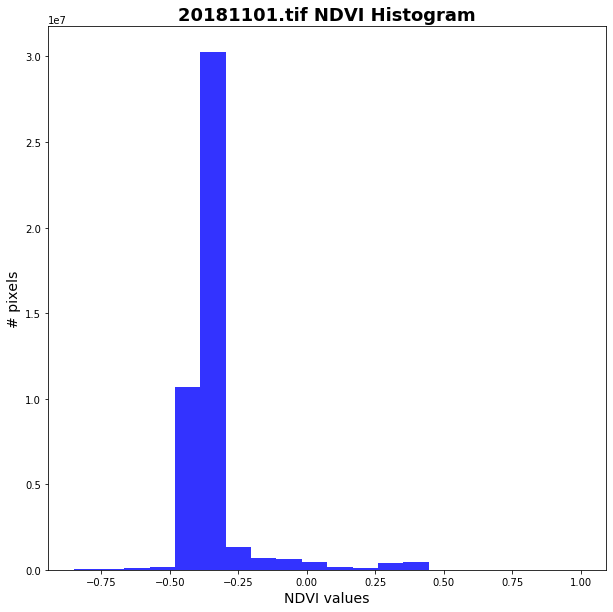

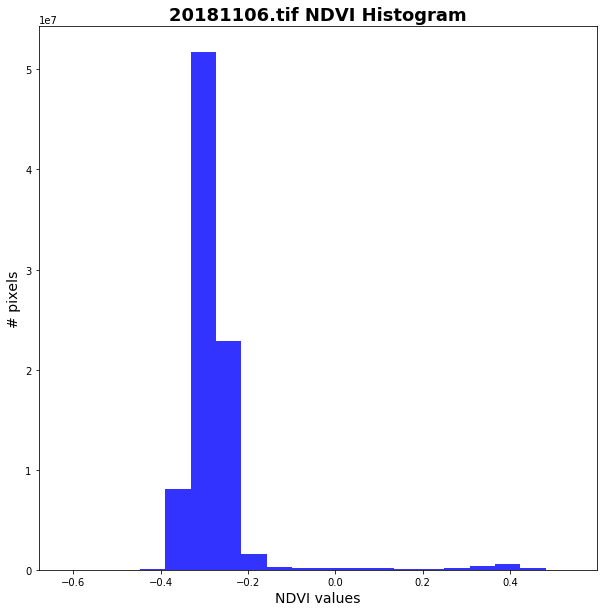

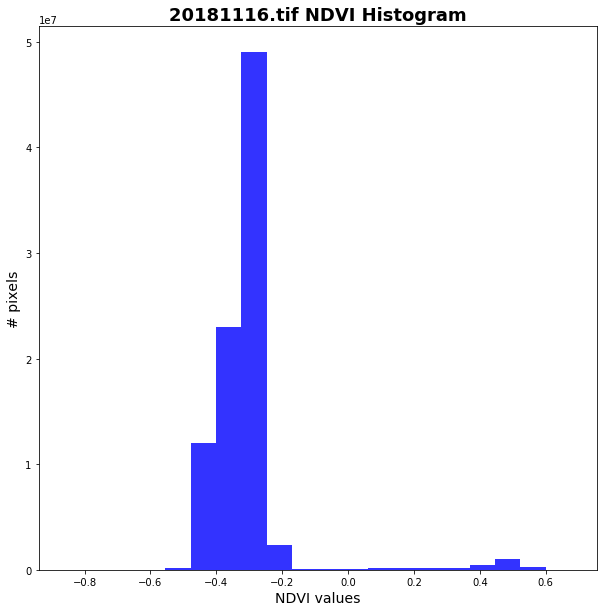

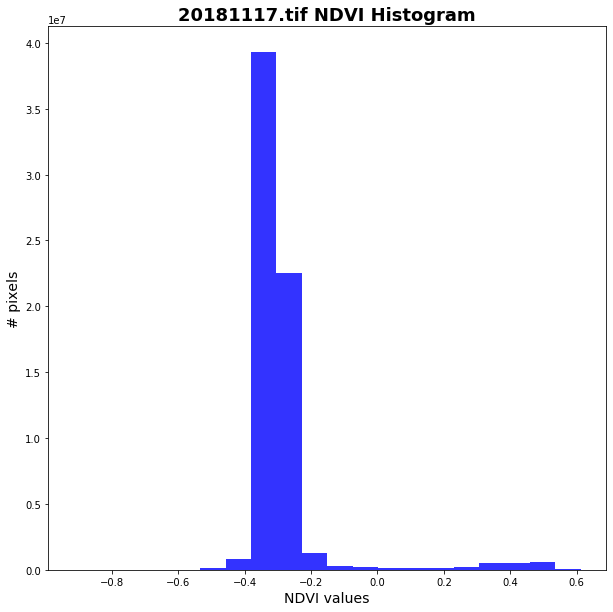

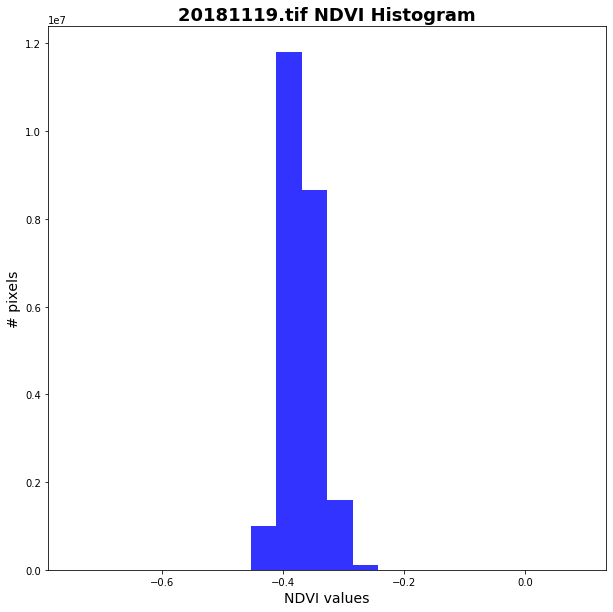

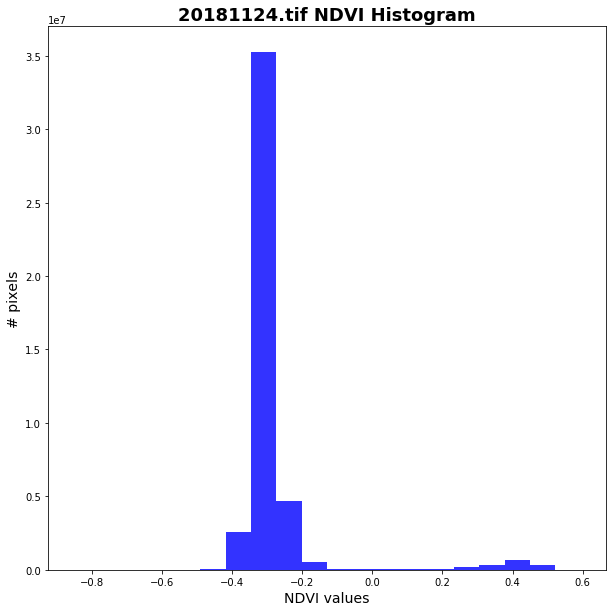

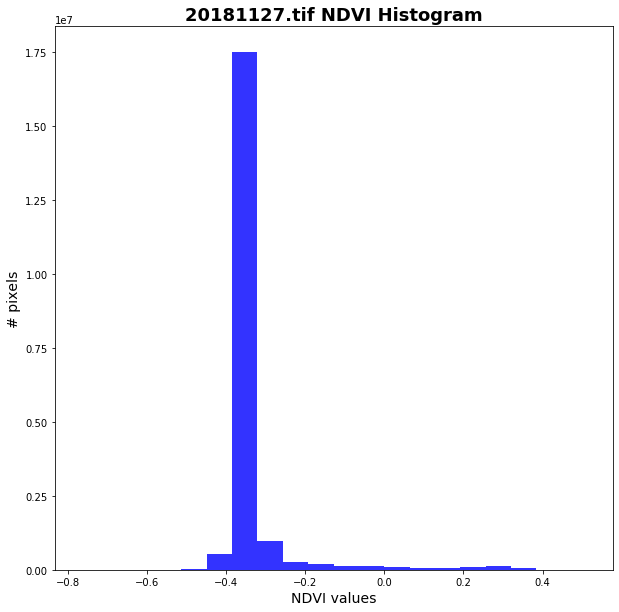

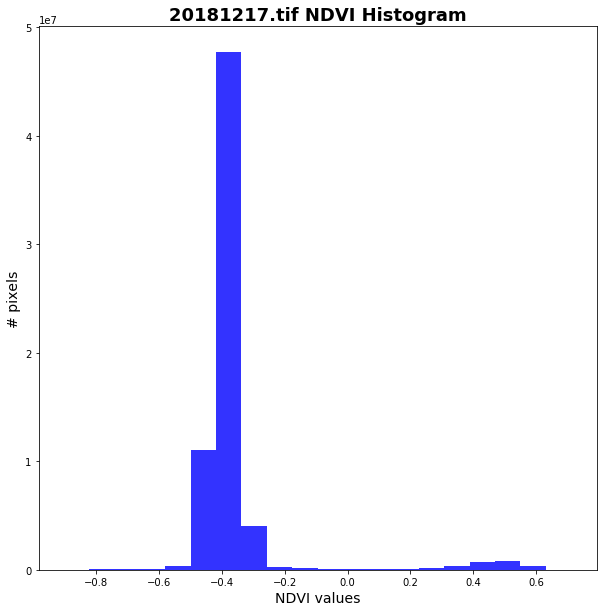

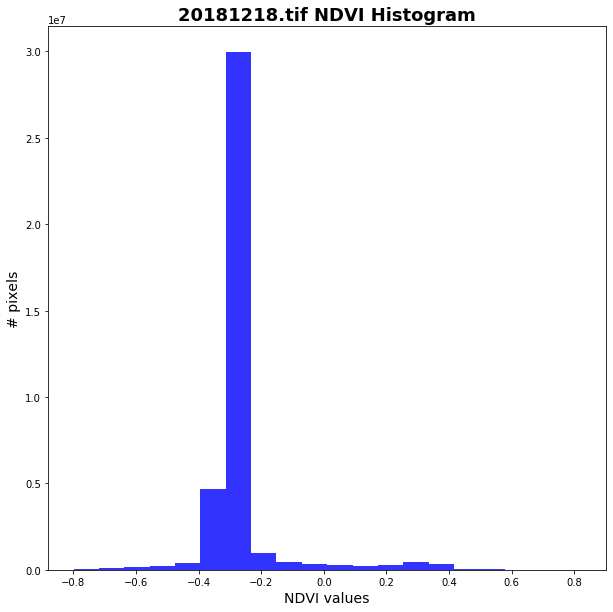

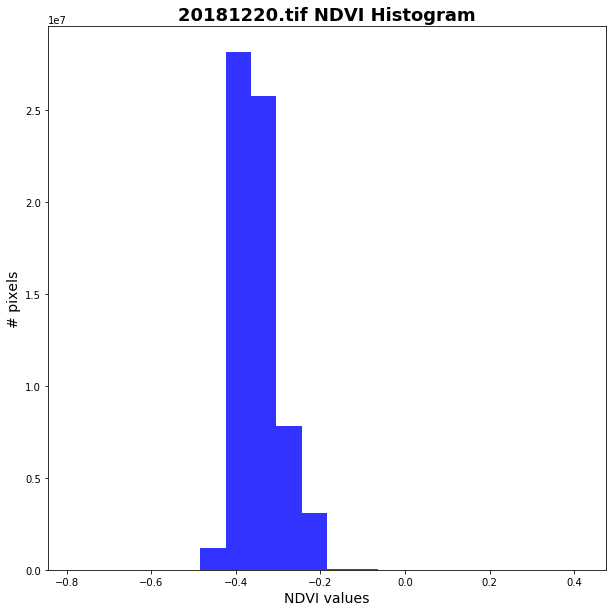

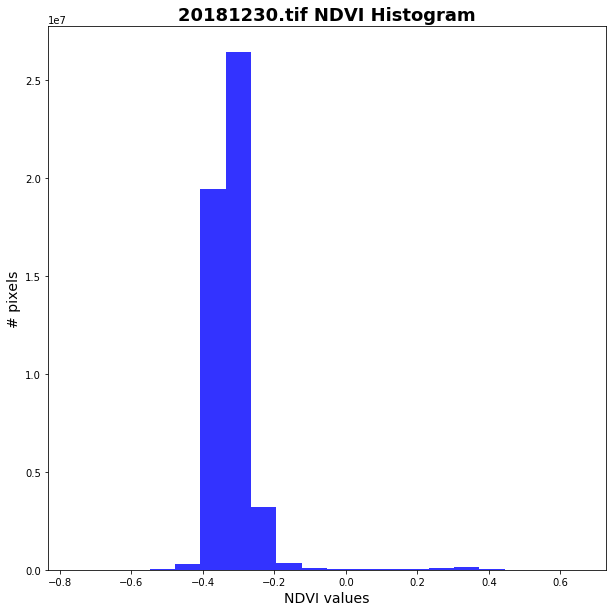

In [196]:
files = []
for r, d, f in os.walk(dp2):
    for file in f:
        files.append(os.path.join(r, file))
        

i = 0
for x in files:
    with rasterio.open(files[i]) as src:
            band_red = src.read(3)
    with rasterio.open(files[i]) as src:
            band_nir = src.read(4)
            
    np.seterr(divide='ignore', invalid='ignore')
    ndvi = ((band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red))
    
    
    kwargs = src.meta
    kwargs.update(
    dtype = rasterio.float32,
    count = 1)
    with rasterio.open('ndvi_' + f[i], 'w', **kwargs) as dst:
        dst.write_band(1, ndvi.astype(rasterio.float32))
        
    
    
    fig2 = plt.figure(figsize=(10,10))
    ax = fig2.add_subplot(111)
    
    plt.title(f[i] + " NDVI Histogram", fontsize=18, fontweight='bold')
    plt.xlabel("NDVI values", fontsize=14)
    plt.ylabel("# pixels", fontsize=14)
    
    b = ndvi[~np.isnan(ndvi)]
    numBins = 20
    ax.hist(b,numBins,color='blue',alpha=0.8)
    
    fig2.savefig("ndvi_" + f[i][0:8] + "_histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

    
    ndvi_adjusted = ndvi * (-255.0)
    masked_ndvi_adjusted = np.ma.array(ndvi_adjusted, mask=np.isnan(ndvi_adjusted))
    cmap = plt.cm.RdYlGn
    cmap.set_bad(color = 'white',alpha = 0.0)
    img = masked_ndvi_adjusted.astype(np.uint8)
    plt.imsave("ndvi_" + f[i][0:8] + "_colormap.tiff", img, cmap=cmap)
       
    i = i + 1

In [197]:
sp3 = os.getcwd()
sf3 = os.listdir(sp3)

for file in sf3:
    if file.startswith('ndvi'):
        shutil.move(os.path.join(sp3,file), os.path.join(sp2,file))

In [198]:
os.chdir(sp2)
os.mkdir('Vegetation_Indices')

In [199]:
sp4 = os.getcwd()
sf4 = os.listdir(sp4)
dp4 = sp2 + '\\Vegetation_Indices'

for file in sf3:
    if file.startswith('ndvi'):
        shutil.move(os.path.join(sp4,file), os.path.join(dp4,file))